<div class="alert alert-info">

Launch in Binder     [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/esowc/UNSEEN-open/master?filepath=doc%2FNotebooks%2Fexamples%2FSiberian_Heatwave.ipynb)

<!-- Or launch an [Rstudio instance](https://mybinder.org/v2/gh/esowc/UNSEEN-open/master?urlpath=rstudio?filepath=doc%2FNotebooks%2FExamples.ipynb)
 -->
</div>

# Californian fires

In August 2020 in California, wildfires have burned more than [ a million acres of land](https://edition.cnn.com/2020/10/06/us/gigafire-california-august-complex-trnd/index.html). 

![California Temperature August 2020](../../../graphs/California_anomaly.png)

Here we retrieve average august temperatures over California within ERA5 1979-2020 to assess how extreme the temperatures have been. We furthermore create an UNSEEN ensemble to assess whether such an event could have been anticipated.  



### Retrieve data

<div class="alert alert-info">

Note
    
In this notebook you cannot use the python functions under Retrieve and Preprocess (they are here only for documentation on the entire workflow, see [retrieve](../1.Download/1.Retrieve.ipynb) if you want to download your own dataset. The resulting preprocessed dataset is provided so you can perform statistical analysis on the dataset and rerun the evaluation and examples provided.
    
</div>

The main functions to retrieve all forecasts (SEAS5) and reanalysis (ERA5) are `retrieve_SEAS5` and `retrieve_ERA5`. We want to download 2m temperature for August over California. By default, the hindcast years of 1981-2016 are downloaded for SEAS5. We include the years 1981-2020. The folder indicates where the files will be stored, in this case outside of the UNSEEN-open repository, in a 'California_example' directory. For more explanation, see [retrieve](../1.Download/1.Retrieve.ipynb).

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../../'))
os.chdir(os.path.abspath('../../../'))

import src.cdsretrieve as retrieve
import src.preprocess as preprocess

import numpy as np
import xarray as xr

In [2]:
retrieve.retrieve_SEAS5(
    variables=['2m_temperature', '2m_dewpoint_temperature'],
    target_months=[8],
    area=[70, -130, 20, -70],
    years=np.arange(1981, 2021),
    folder='E:/PhD/California_example/SEAS5/')

In [6]:
retrieve.retrieve_ERA5(variables=['2m_temperature', '2m_dewpoint_temperature'],
                       target_months=[8],
                       area=[70, -130, 20, -70],
                       folder='E:/PhD/California_example/ERA5/')

### Preprocess

In the preprocessing step, we first merge all downloaded files into one xarray dataset, then take the spatial average over the domain and a temporal average over the MAM season. Read the docs on [preprocessing](../2.Preprocess/2.Preprocess.ipynb) for more info. 

In [8]:
SEAS5_California = preprocess.merge_SEAS5(folder ='E:/PhD/California_example/SEAS5/', target_months = [8])

Lead time: 07
6
5
4
3


And for ERA5:

In [10]:
ERA5_California = xr.open_mfdataset('E:/PhD/California_example/ERA5/ERA5_????.nc',combine='by_coords')

We calculate the [standardized anomaly of the 2020 event](../California_august_temperature_anomaly.ipynb) and select the 2m temperature over the region where 2 standard deviations from the mean was exceeded. This is a simple average, an area-weighed average is more appropriate, since grid cell area decreases with latitude, see [preprocess](../2.Preprocess/2.Preprocess.ipynb). 

In [ ]:
ERA5_anomaly = ERA5_California['t2m'] - ERA5_California['t2m'].mean('time')
ERA5_sd_anomaly = ERA5_anomaly / ERA5_California['t2m'].std('time')

In [13]:
ERA5_California_events = (
    ERA5_California['t2m'].sel(  # Select 2 metre temperature
        longitude=slice(-120, -100)).    # Select the longitude
    where(ERA5_sd_anomaly.sel(time = '2020').squeeze('time')>2). ##Mask the region where 2020 sd >2. 
    mean(['longitude', 'latitude'])) #And take the mean

Plot the August temperatures over the defined California domain: 

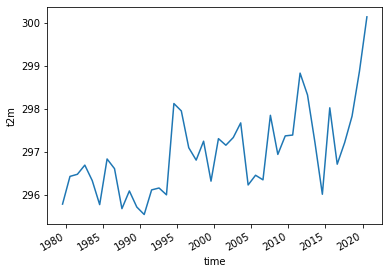

In [20]:
ERA5_California_events.plot()

Select the same domain for SEAS5 and extract the events.

In [22]:
SEAS5_California_events = (
    SEAS5_California['t2m'].sel(
        longitude=slice(-120, -100)).
    where(ERA5_sd_anomaly.sel(time = '2020').squeeze('time')>2).
    mean(['longitude', 'latitude']))

And here we store the data in the Data section so the rest of the analysis in R can be reproduced. 

In [23]:
SEAS5_California_events.to_dataframe().to_csv('Data/SEAS5_California_events.csv')
ERA5_California_events.to_dataframe().to_csv('Data/ERA5_California_events.csv')

C:\anaconda3\envs\unseen\lib\site-packages\dask\array\numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### Evaluate


<div class="alert alert-info">

Note

From here onward we use R and not python!
    
We switch to R since we believe R has a better functionality in extreme value statistics. 

</div>

In [1]:
setwd('../../..')
getwd()
SEAS5_California_events <- read.csv("Data/SEAS5_California_events.csv", stringsAsFactors=FALSE)
ERA5_California_events <- read.csv("Data/ERA5_California_events.csv", stringsAsFactors=FALSE)

## Convert Kelvin to Celsius
SEAS5_California_events$t2m <- SEAS5_California_events$t2m - 273.15
ERA5_California_events$t2m <- ERA5_California_events$t2m - 273.15

## Convert character time to Date format
ERA5_California_events$time <- lubridate::ymd(ERA5_California_events$time)
SEAS5_California_events$time <- lubridate::ymd(SEAS5_California_events$time)

[1] "C:/Users/Timo/OneDrive - Loughborough University/GitHub/UNSEEN-open"

*Is the UNSEEN ensemble realistic?* 

To answer this question, we perform three statistical tests: independence, model stability and model fidelity tests.  
These statistical tests are available through the [UNSEEN R package](https://github.com/timokelder/UNSEEN). 
See [evaluation](../3.Evaluate/3.Evaluate.ipynb) for more info.

In [2]:
require(UNSEEN)

Loading required package: UNSEEN



#### Timeseries
<a id='Timeseries'></a>

We plot the timeseries of SEAS5 (UNSEEN) and ERA5 (OBS) for the the Siberian Heatwave. 

You can call the documentation of the function with `?unseen_timeseries`

Warning message:
"Removed 4680 rows containing non-finite values (stat_boxplot)."


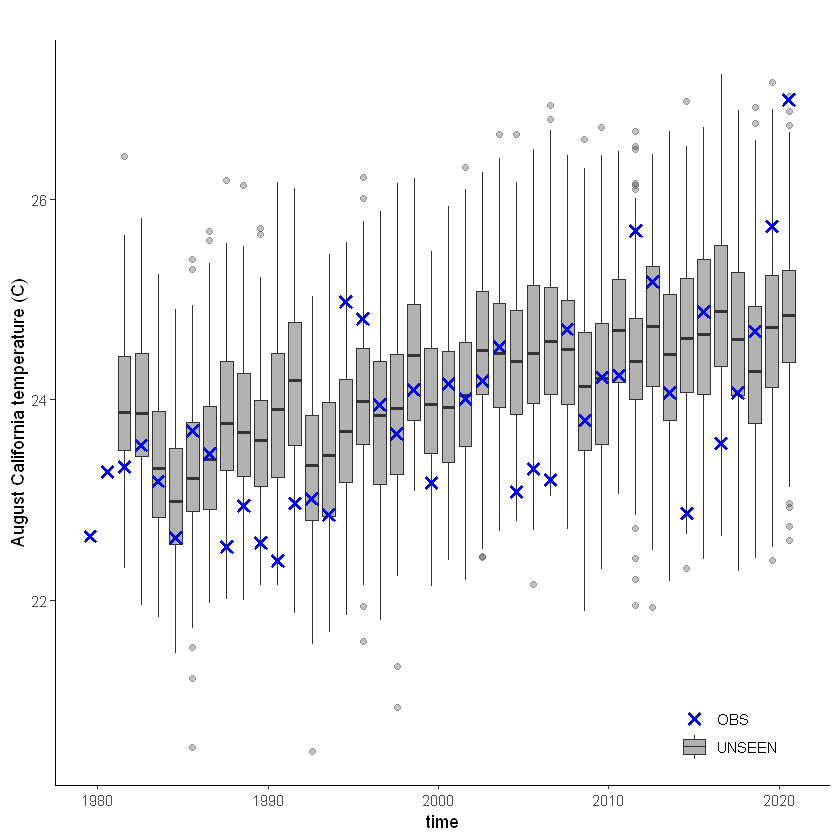

In [4]:
unseen_timeseries(
    ensemble = SEAS5_California_events,
    obs = ERA5_California_events,
    ensemble_yname = "t2m",
    ensemble_xname = "time",
    obs_yname = "t2m",
    obs_xname = "time",
    ylab = "August California temperature (C)")

The timeseries consist of **hindcast (years 1982-2016)** and **archived forecasts (years 2017-2020)**. The datasets are slightly different: the hindcasts contains 25 members whereas operational forecasts contain 51 members, the native resolution is different and the dataset from which the forecasts are initialized is different. 

**For the evaluation of the UNSEEN ensemble we want to only use the SEAS5 hindcasts for a consistent dataset**. Note, 2017 is not used in either the hindcast nor the operational dataset, since it contains forecasts both initialized in 2016 (hindcast) and 2017 (forecast), see [retrieve](../1.Download/1.Retrieve.ipynb).
We split SEAS5 into hindcast and operational forecasts:

In [5]:
SEAS5_California_events_hindcast <- SEAS5_California_events[
    SEAS5_California_events$time < '2017-02-01' &
    SEAS5_California_events$number < 25,]

SEAS5_California_events_forecasts <- SEAS5_California_events[
    SEAS5_California_events$time > '2017-02-01',]

And we select the same years for ERA5. 

In [14]:
ERA5_California_events_hindcast <- ERA5_California_events[
    ERA5_California_events$time > '1981-02-01' &
    ERA5_California_events$time < '2017-02-01',]

Which results in the following timeseries:

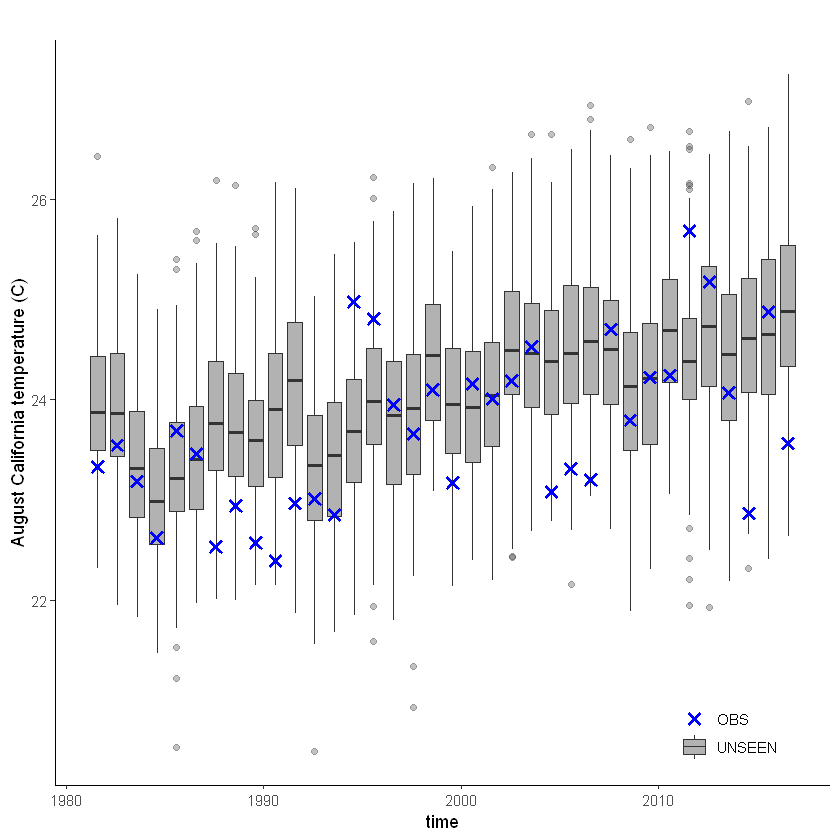

In [15]:
unseen_timeseries(
    ensemble = SEAS5_California_events_hindcast,
    obs = ERA5_California_events_hindcast,
    ensemble_yname = "t2m",
    ensemble_xname = "time",
    obs_yname = "t2m",
    obs_xname = "time",
    ylab = "August California temperature (C)")

#### Evaluation tests
With the hindcast dataset we evaluate the independence, stability and fidelity. Here, we plot the results for the fidelity test, for more detail on the other tests see the [evaluation section](../3.Evaluate/3.Evaluate.ipynb). 

The fidelity test shows us how consistent the model simulations of UNSEEN (SEAS5) are with the observed (ERA5). The UNSEEN dataset is much larger than the observed -- hence they cannot simply be compared. For example, what if we had faced a few more or a few less heatwaves purely by chance? 

This would influence the observed mean, but not so much influence the UNSEEN ensemble because of the large data sample. Therefore we express the UNSEEN ensemble as a range of plausible means, for data samples of the same length as the observed. We do the same for higher order [statistical moments](https://en.wikipedia.org/wiki/Moment_(mathematics)). 

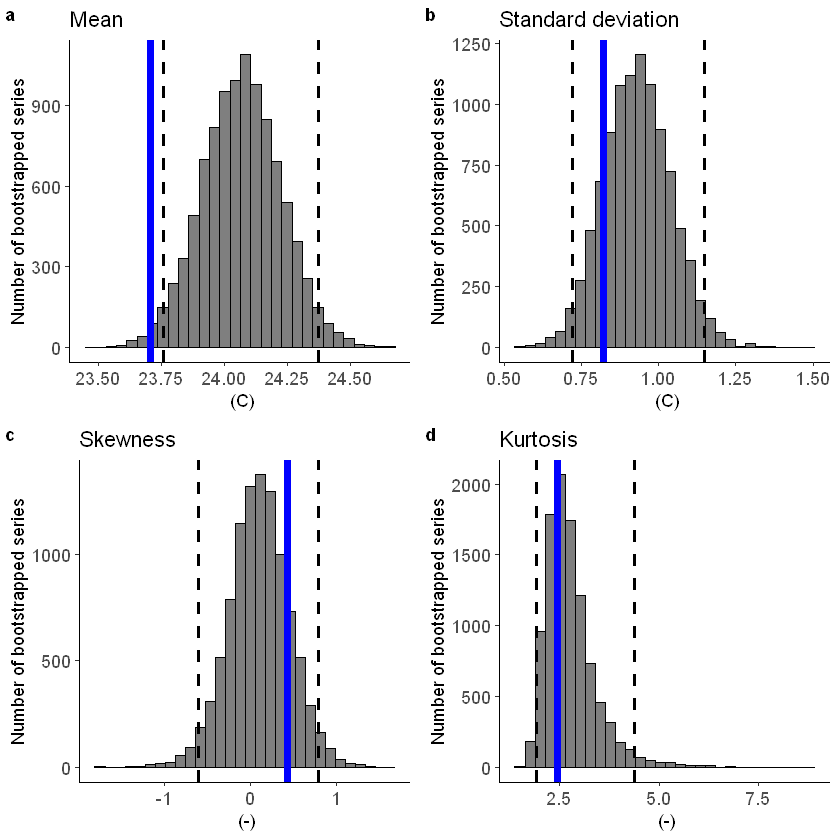

In [16]:
fidelity_test(
    obs = ERA5_California_events_hindcast$t2m,
    ensemble = SEAS5_California_events_hindcast$t2m,
    units = 'C',
    biascor = FALSE
)

The fidelity test shows that the mean of the UNSEEN ensemble is too low compared to the observed -- the blue line falls outside of the model range in a. To correct for this low bias, we can apply an additive bias correction, which only corrects the mean of the simulations. 

Lets apply the additive biascor:

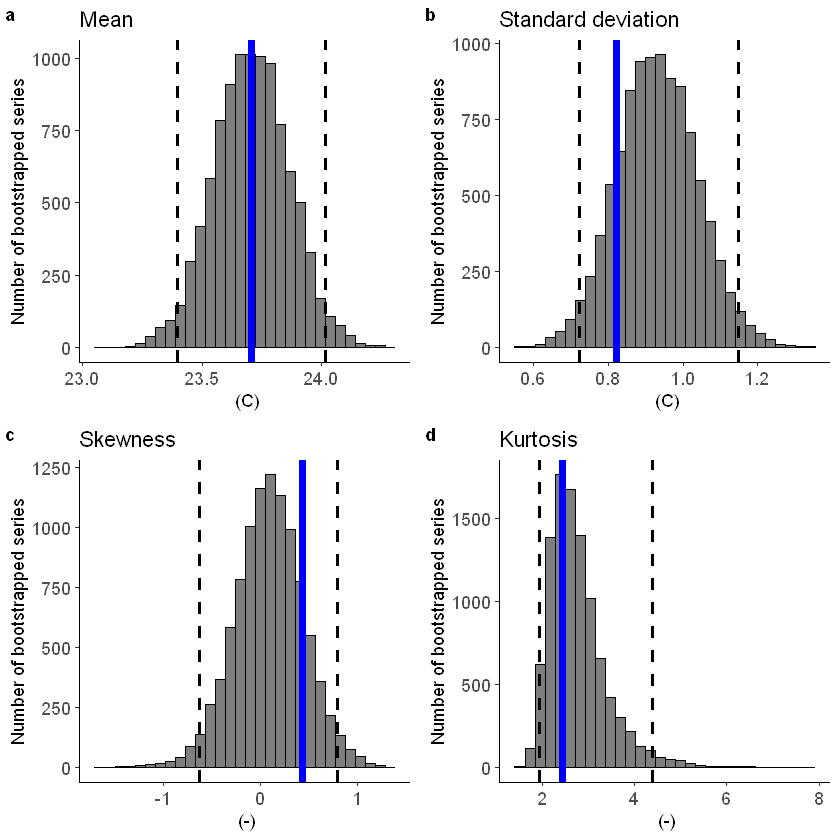

In [18]:
obs = ERA5_California_events_hindcast$t2m
ensemble = SEAS5_California_events_hindcast$t2m
ensemble_biascor = ensemble + (mean(obs) - mean(ensemble))

fidelity_test(
    obs = obs,
    ensemble = ensemble_biascor,
    units = 'C',
    biascor = FALSE
)

This shows us what we expected: the mean bias is corrected because the model simulations are shifted up (the blue line is still the same, the axis has just shifted along with the histogram), but the other statistical moments are the same. 

### Illustrate

In [19]:
source('src/evt_plot.r')

Loading required package: Lmoments

Loading required package: distillery


Attaching package: 'extRemes'


The following objects are masked from 'package:stats':

    qqnorm, qqplot




First, we fit a Gumbel and a GEV distribution (including shape parameter) to the observed extremes. The Gumbel distribution best describes the data because the p-value of 0.51 is much above 0.05 (based on the likelihood ratio test). 

In [20]:
fit_obs_Gumbel <- fevd(x = obs,
                    type = "Gumbel"
                   )
fit_obs_GEV <- fevd(x = obs,
                    type = "GEV"
                   )
lr.test(fit_obs_Gumbel, fit_obs_GEV)


	Likelihood-ratio Test

data:  obsobs
Likelihood-ratio = 0.43417, chi-square critical value = 3.8415, alpha =
0.0500, Degrees of Freedom = 1.0000, p-value = 0.5099
alternative hypothesis: greater


We show the gumbel plot for the observed (ERA5) and UNSEEN (SEAS5 hindcast data). This shows that the UNSEEN simulations are not within the uncertainty range of the observations. This has likely two reasons, illustrated in the evaluation section: there is some dependence between the events and there is too little variability within the UNSEEN ensemble. 

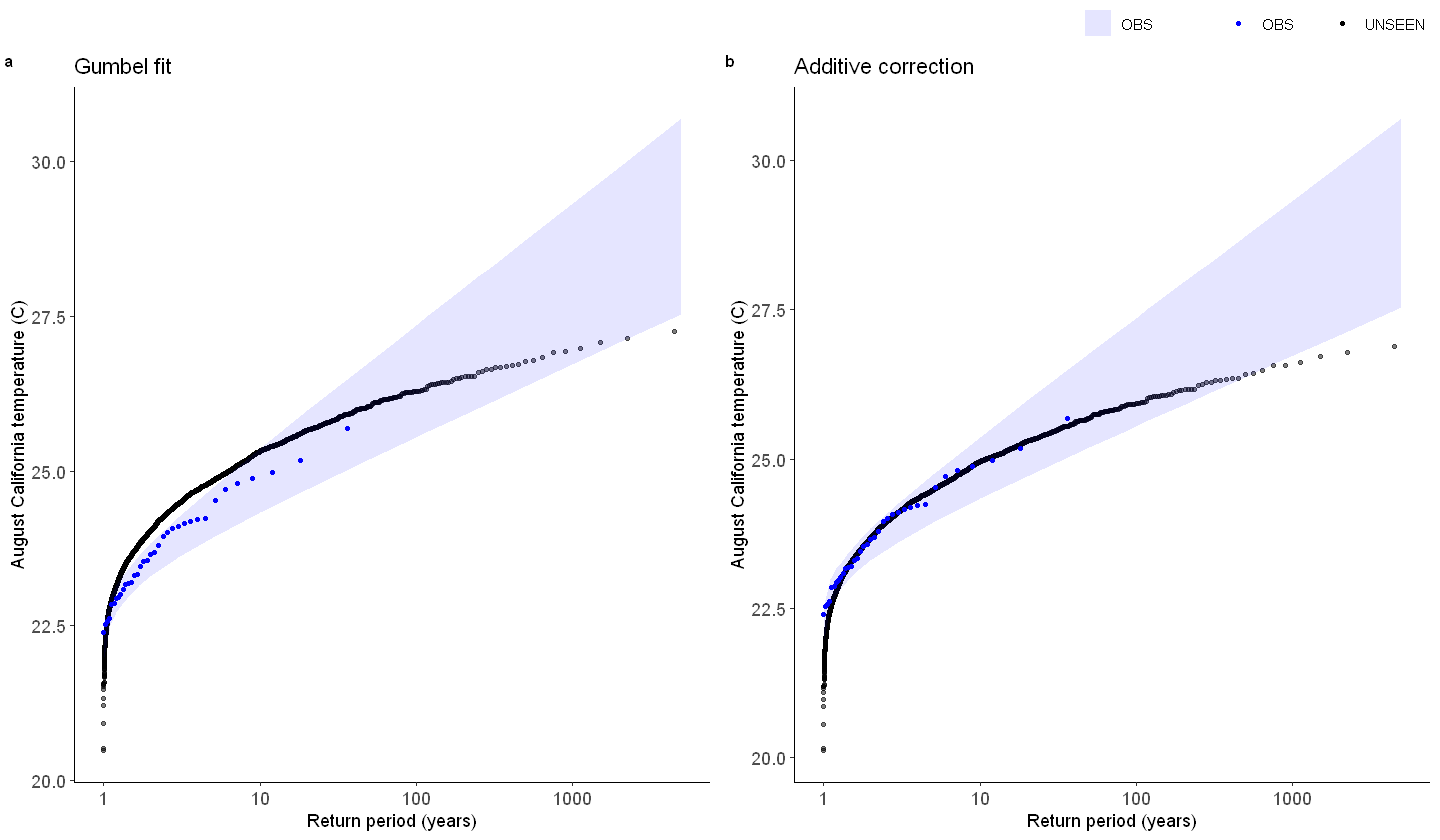

In [22]:
options(repr.plot.width = 12)
GEV_hindcast <- EVT_plot(ensemble = ensemble,
                         obs = obs,
                         main = "Gumbel fit",
                         GEV_type = "Gumbel",
#                          ylim = 3,
                         y_lab = 'August California temperature (C)'
                        ) 
GEV_hindcast_corrected <- EVT_plot(ensemble = ensemble_biascor, #SEAS5_Siberia_events_zoomed_hindcast$t2m,
                                   obs = obs,
                                   main = "Additive correction",
                                   GEV_type = "Gumbel",
#                                    ylim = 3,
                                   y_lab = 'August California temperature (C)'
                                  ) 

ggarrange(GEV_hindcast, GEV_hindcast_corrected,
  labels = c("a", "b"), # ,"c","d"),
  common.legend = T,
  font.label = list(size = 10, color = "black", face = "bold", family = NULL),
  ncol = 2, nrow = 1
)

So what can we get out of it? What if we look at the operational forecast? Even if we cannot use the dataset as a whole to estimate the likelihood of occurrence, have events similar to the 2020 event occurred?  

We select 2018-2020 archived SEAS5 forecasts as UNSEEN events, check out the [timeseries section](#Timeseries) for more info on the difference between the hindcast data and the archived forecasts. We furthermore select all ERA5 (observed) events except for the 2020 event as reference to estimate the likelihood of the 2020 event.

In [24]:
ERA5_events_min2020 <- ERA5_California_events[1:length(ERA5_California_events$t2m)-1,]
ERA5_events_2020 <- ERA5_California_events[length(ERA5_California_events$t2m),]

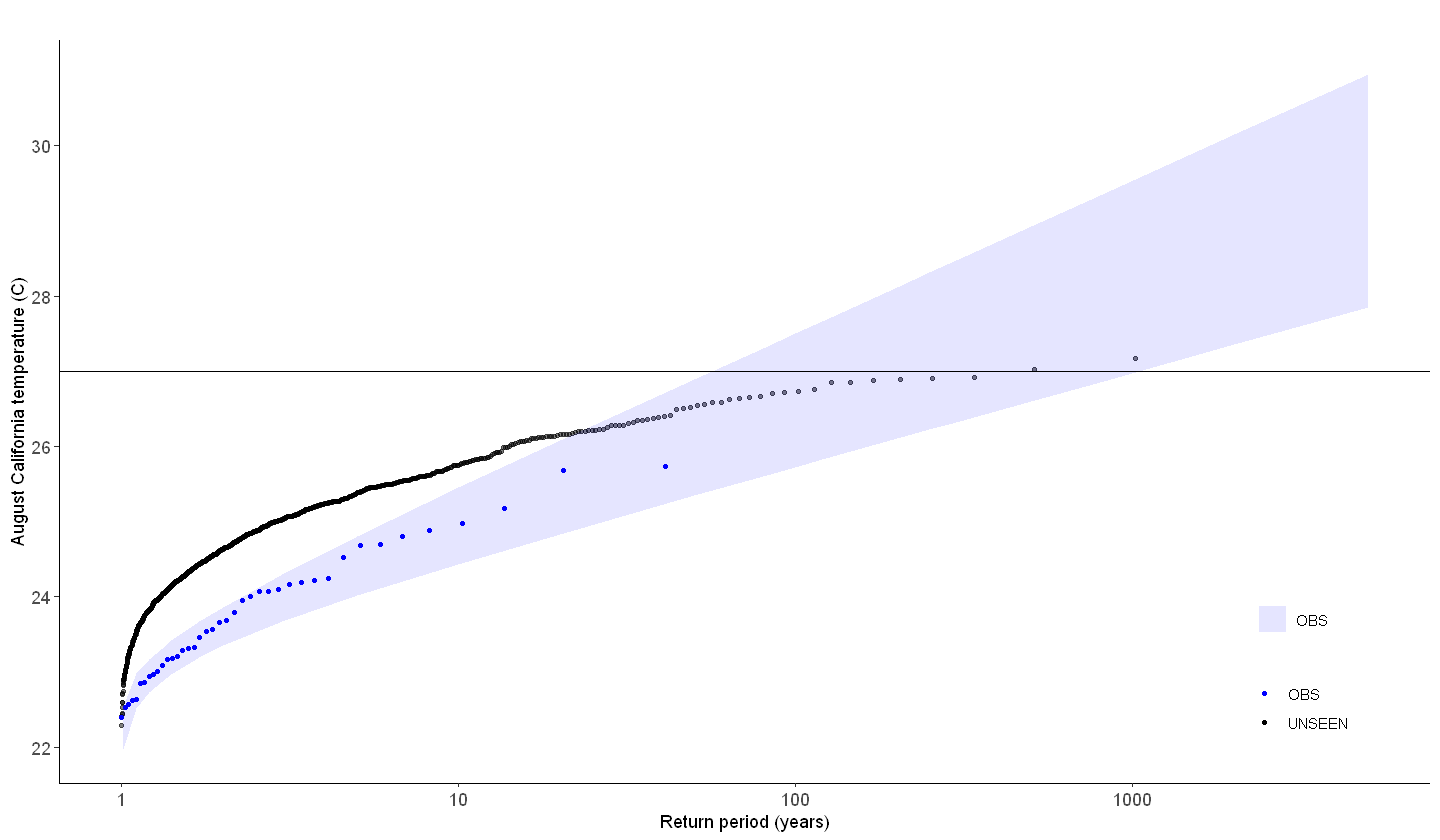

In [26]:
GEV_forecasts <- EVT_plot(ensemble = SEAS5_California_events_forecasts$t2m,
                          obs = ERA5_events_min2020$t2m,
                          main = "",
                          GEV_type = "Gumbel",
#                           ylim = 3,
                          y_lab = 'August California temperature (C)'
                         ) # %>%
GEV_forecasts + geom_hline(yintercept = ERA5_events_2020$t2m)

**Applications:**

Prolonged heat events with an average temperature above 0 degrees over Siberia can have enormous impacts on the local environment, such as wildfires, invasion of pests and infrastructure failure, and on the global environment, through the release of greenhouse gasses during permafrost thawing. 

1. Assessing the drivers of the most severe events. The 2020 event seemed to be caused by a very anomalous Indian Ocean Dipole (IOD). What can we learn from the highest UNSEEN events? To what extent are these also driven by an anomalous IOD or are there other drivers of such severe heat events? 
2. Nonstationary analysis. There seems to be a trend over the hindcast period in the severe heatwaves. We can perform non-stationary analysis to estimate the change in the magnitude and frequency of the heatwaves and, if we find a change, we could explore the drivers of this change. 